**This notebook is only used as an example. Detailed doc string is in the CNN_Model.py file.** 

# Import Necessary Package

In [1]:
import os
import cv2
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Pre-Processing
* For the training process, get image from the directory and put label it.
* For the predicting process, get image from the dirctory only.

In [2]:
# Initiate the path list for both of training and predict
TRAINING = ['Nyquist/Noisy', 'Nyquist/SingleHump', 
            'Nyquist/TwoHumps', 'Nyquist/Tail', 'EIS_training.npy']
PREDICT = ['Nyquist/Random', 'EIS_predicting.npy']

# Initiate some parameter
image_width = 800
image_height = 536

In [3]:
class EISDataImport():
    """Data Import and Pre-Processing"""

    def DataImporter_Training(self, k, path_List_training,
                              image_width, image_height):
        path_list = path_List_training
        countImage_Training = [0, 0, 0, 0, 0, 0, 0]
        training_data = []
        # Iterate the directory
        for label in range(len(path_list)-1):
            print(path_list[label])
            # Iterate all the image within the directory, f -> the file name
            for f in tqdm(os.listdir(path_list[label])):
                # Get the full path to the image
                path = os.path.join(path_list[label], f)
                if "png" in path:
                    # Read images in the given path and turn into nparray.
                    # Convert the iimage to gray scale (optional)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (image_width, image_height))
                    # Label the image with np.eye() matrix.
                    training_data.append([path, np.array(img),
                                          np.eye(k)[label]])
                    for i in range(k):
                        if label == i:
                            countImage_Training[i] += 1

        np.random.shuffle(training_data)
        np.save(path_list[-1], training_data)
        for i in range(len(path_list)-1):
            print(path_List_training[i], ":", countImage_Training[i])

    def DataImporter_Predict(self, k, path_List_predict,
                             image_width, image_height):

        path_list = path_List_predict
        countImage_Predict = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        training_data = []
        # Iterate the directory
        for label in range(len(path_list)-1):
            print(path_list[label])
            # Iterate all the image within the directory, f -> the file name
            for f in tqdm(os.listdir(path_list[label])):
                # Get the full path to the image
                path = os.path.join(path_list[label], f)
                if "png" in path:
                    # Read images in the given path and turn into nparray.
                    # Convert the iimage to gray scale (optional)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (image_width, image_height))
                    training_data.append([path, np.array(img)])
                    # Count the number of image
                    for i in range(k):
                        if label == i:
                            countImage_Predict[i] += 1

        np.random.shuffle(training_data)
        np.save(path_list[-1], training_data)
        for i in range(len(path_list)-1):
            print(path_List_predict[i], ":", countImage_Predict[i])

In [4]:
def Build_Data(Training, Predict, k, path_list, image_width, image_height):
    Class = EISDataImport()
    if Training is True:
        Class.DataImporter_Training(k, path_list, image_width, image_height)
    if Predict is True:
        Class.DataImporter_Predict(k, path_list, image_width, image_height)

# Model Training
Use the data to train the neural network model.

In [5]:
# Import image for training
Build_Data(True, False, 4, TRAINING, image_width, image_height)

Nyquist/Noisy


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 130.43it/s]


Nyquist/SingleHump


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.99it/s]


Nyquist/TwoHumps


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:01<00:00, 149.37it/s]


Nyquist/Tail


100%|███████████████████████████████████████████████████████████████████████████████| 197/197 [00:01<00:00, 144.41it/s]


Nyquist/Noisy : 198
Nyquist/SingleHump : 199
Nyquist/TwoHumps : 199
Nyquist/Tail : 196


The images importing in the program will be transformed into array and stored in a ".npy" file.

In [6]:
def load_array_data(np_ndarray_file): 
    array_data = np.load(np_ndarray_file, allow_pickle=True)
    return array_data

In [7]:
# Load the data from the ".npy" file.
training_data = load_array_data(TRAINING[-1])

### Data Status Check

In [12]:
# Check the informaiton for image in array form
def data_information(array_data):
    print("Type of input_data:", type(array_data))
    print("Size of imput_data:", len(array_data))
    print("Size of image(after rescale):", array_data[0][1].shape[1],
          "x", array_data[0][1].shape[0])

In [13]:
data_information(training_data)

Type of input_data: <class 'numpy.ndarray'>
Size of imput_data: 792
Size of image(after rescale): 800 x 536


In [14]:
# Plot the image with array data to check if it's successfully loaded into the program
def ploting_data(input_data, i): # i is for arbitrarily assigning the image to plot
    print(input_data[i][0])  # Print out the file name (path).
    plt.imshow(input_data[i][1])
    plt.show()

Nyquist/TwoHumps\200315-1852_sim_spread.png


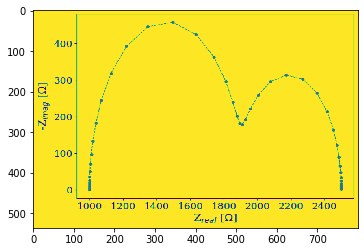

In [15]:
ploting_data(training_data, 0)

### Convolutional Neural Network

In [16]:
# Initiate the parameter for neural network
input_size = 1
firstHidden = 8
kernel_size = 5
output_size = 4

In [17]:
class Net(nn.Module):
    """Convolutional Neural Network Model"""
    def __init__(self, input_size, image_width, image_height,
                 firstHidden, kernel_size, output_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(input_size, firstHidden, kernel_size)
        self.conv2 = nn.Conv2d(firstHidden, firstHidden*2, kernel_size)
        self.conv3 = nn.Conv2d(firstHidden*2, firstHidden*4, kernel_size)
        self.conv4 = nn.Conv2d(firstHidden*4, firstHidden*8, kernel_size)
        #
        x = torch.randn(image_height, image_width).view(-1, 1, image_height,
                                                        image_width)
        conv_to_linear = self.last_conv_neuron(x)

        self.fc1 = nn.Linear(conv_to_linear, 64)
        self.fc2 = nn.Linear(64, output_size)

    def last_conv_neuron(self, x):
        x = self.convs(x)
        conv_to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return conv_to_linear

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        return x

    def forward(self, x):
        x = self.convs(x)
        conv_to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        # Flatten the data
        xF = x.view(-1, conv_to_linear)
        # Put into the first fully connected layer
        output = F.relu(self.fc1(xF))
        output = self.fc2(output)
        return F.softmax(output, dim=1)

In [19]:
# Show the architecture for the CNN
net = Net(input_size, image_width, image_height,
          firstHidden, kernel_size, output_size)
net

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=85376, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

#### Data Type Transform
Because pytorch package usually deal with the data in tensor form. We have to transform our array data into tensor data.
* image: imagesfrom the user which have already been transformed into array form. 
* type: Labels put with the images by using np.eye matrix. (Also the array form)

In [20]:
def image_to_tensor(array_data, image_width, image_height):
    tensor_image = torch.Tensor([i[1] for i in array_data]
                                ).view(-1, image_height, image_width)
    return tensor_image

In [21]:
training_image_tensor = image_to_tensor(training_data, image_width, image_height)

In [22]:
def type_to_tensor(array_data):
    tensor_type = torch.Tensor([i[2] for i in array_data])
    return tensor_type

In [23]:
training_type_tensor = type_to_tensor(training_data)

#### Data Sepatation
Because we hope to figure the accuracy of the model, we need to separate the data into two part(training, testing)
* training_sample_image
* training_sample_type
* testing_sample_image
* testing_sample_type

In [25]:
def data_separation(tensor_data, ratio_of_testing, TRAIN, TEST):
    VAL_PCT = ratio_of_testing
    val_size = int(len(tensor_data)*VAL_PCT)

    if TRAIN is True:
        training_sample = tensor_data[:-val_size]
        print("Training Samples:", len(training_sample))
        return training_sample
    
    if TEST is True:
        testing_sample = tensor_data[-val_size:]
        print("Testing Samples:", len(testing_sample))
        return testing_sample

In [26]:
training_sample_image = data_separation(training_image_tensor, 0.2, True, False)

Training Samples: 634


In [27]:
training_sample_type = data_separation(training_type_tensor, 0.2, True, False)

Training Samples: 634


In [28]:
testing_sample_image = data_separation(training_image_tensor, 0.2, False, True)

Testing Samples: 158


In [29]:
testing_sample_type = data_separation(training_type_tensor, 0.2, False, True)

Testing Samples: 158


#### Learning and Calculating the Accuracy

In [35]:
# Initiate the parameter for learning function
learning_rate = 0.001
BATCH_SIZE = 10
EPOCHS = 1

In [36]:
def learning(training_sample_image, training_sample_type, input_size,
             image_width, image_height, firstHidden, kernel_size, output_size,
             learning_rate, BATCH_SIZE, EPOCHS):
        
    optimizer = optim.Adam(Net(input_size, image_width, image_height,
                               firstHidden, kernel_size, output_size
                               ).parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(training_sample_image), BATCH_SIZE)):
            batch_image = training_sample_image[i:i+BATCH_SIZE
                                                ].view(-1, 1, image_height,
                                                       image_width)
            batch_type = training_sample_type[i:i+BATCH_SIZE]

            Net(input_size, image_width, image_height, firstHidden,
                kernel_size, output_size).zero_grad()
            outputs = Net(input_size, image_width, image_height, firstHidden,
                          kernel_size, output_size)(batch_image)
            loss = loss_function(outputs, batch_type)
            loss.backward()
            optimizer.step()

        print(loss)

In [37]:
learning(training_sample_image, training_sample_type, input_size,
             image_width, image_height, firstHidden, kernel_size, output_size,
             learning_rate, BATCH_SIZE, EPOCHS)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [03:23<00:00,  3.18s/it]


tensor(0.3726, grad_fn=<MseLossBackward>)


In [38]:
def accuracy(testing_sample_image, testing_sample_type, input_size,
             image_width, image_height, firstHidden, kernel_size,
             output_size):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(testing_sample_image))):
            real_type = torch.argmax(testing_sample_type[i])
            net_out_train = Net(input_size, image_width, image_height,
                                firstHidden, kernel_size, output_size
                                )(testing_sample_image[i].view(-1, 1,
                                                               image_height,
                                                               image_width
                                                               ))[0]
            predicted_type = torch.argmax(net_out_train)

            if predicted_type == real_type:
                correct += 1
            total += 1

    predicting_accuracy = round(correct/total, 3)
    print("Accuracy:", predicting_accuracy)
    return predicting_accuracy

In [39]:
Acc = accuracy(testing_sample_image, testing_sample_type, input_size,
              image_width, image_height, firstHidden, kernel_size,
              output_size)

100%|████████████████████████████████████████████████████████████████████████████████| 158/158 [01:33<00:00,  1.70it/s]


Accuracy: 0.241


# Model Test
Use the random data to test the neural network model.

In [40]:
# Import image for test
Build_Data(True, False, 1, PREDICT, image_width, image_height)

Nyquist/Random


100%|███████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 140.51it/s]


Nyquist/Random : 140


In [41]:
testing_data = load_array_data(PREDICT[-1])

In [42]:
data_information(testing_data)

Type of input_data: <class 'numpy.ndarray'>
Size of imput_data: 140
Size of image(after rescale): 800 x 536


Nyquist/Random\200315-0138_randles_simp.png


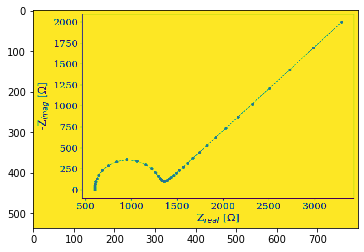

In [43]:
ploting_data(testing_data, 1)

In [44]:
testing_image_tensor = image_to_tensor(testing_data, image_width, image_height)

In [45]:
testing_type_tensor = type_to_tensor(testing_data)

In [74]:
def type_prediction(k, path_List_training, tensor_data, array_data,
                    input_size, image_width, image_height, firstHidden,
                    kernel_size, output_size, detailed_information):
    
    countImage_predicted_type = [0, 0, 0, 0, 0, 0, 0]
    for i in range(len(tensor_data)):
        net_out_predict = Net(input_size, image_width, image_height,
                              firstHidden, kernel_size, output_size
                              )(tensor_data[i].view(-1, 1, image_height,
                                                    image_width))[0]
        predicted_type = torch.argmax(net_out_predict)
        for Type in range(k):
            if predicted_type == Type:
                countImage_predicted_type[Type] += 1
                # Print out the detailed information.
                if i < 10: # only print out the detailed information for the first 10 images                    
                    if detailed_information is True:
                        print("Type Prediction:", path_List_training[Type])
                        print("  Path and File Name:", array_data[i][0])
                        #print("Image No.", i+1, predicted_type, )
                        #plt.imshow(array_data[i][1])
                        #plt.show()                    
                        print()

    for i in range(len(path_List_training)-1):
        print(path_List_training[i], ":", countImage_predicted_type[i])


In [75]:
type_prediction(4, TRAINING, testing_image_tensor, testing_data,
                    input_size, image_width, image_height, firstHidden,
                    kernel_size, output_size, True)

Type Prediction: Nyquist/TwoHumps
  Path and File Name: Nyquist/Random\200315-0129_randles_simp.png

Type Prediction: Nyquist/TwoHumps
  Path and File Name: Nyquist/Random\200315-0138_randles_simp.png

Type Prediction: Nyquist/SingleHump
  Path and File Name: Nyquist/Random\200315-0350_sim_spread.png

Type Prediction: Nyquist/Noisy
  Path and File Name: Nyquist/Random\200315-0090_sim_one.png

Type Prediction: Nyquist/SingleHump
  Path and File Name: Nyquist/Random\200315-0114_randles_simp.png

Type Prediction: Nyquist/SingleHump
  Path and File Name: Nyquist/Random\200315-0364_sim_spread.png

Type Prediction: Nyquist/Noisy
  Path and File Name: Nyquist/Random\200315-0103_sim_one.png

Type Prediction: Nyquist/Tail
  Path and File Name: Nyquist/Random\200315-0390_sim_spread.png

Type Prediction: Nyquist/SingleHump
  Path and File Name: Nyquist/Random\200315-0092_sim_one.png

Type Prediction: Nyquist/SingleHump
  Path and File Name: Nyquist/Random\200315-0113_sim_one.png

Nyquist/Noisy : 